In [3]:
%pip install --quiet dgl
%pip install --quiet dgllife

Note: you may need to restart the kernel to use updated packages.
ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: '/opt/conda/lib/python3.6/site-packages/six-1.16.0.dist-info/METADATA'

Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install --quiet rdkit-pypi

Note: you may need to restart the kernel to use updated packages.


In [5]:
from functools import partial
import numpy as np
import torch
import torch.nn as nn
import pandas as pd

import dgl
from dgllife.model import load_pretrained
from dgllife.utils import smiles_to_bigraph, EarlyStopping, Meter, CanonicalAtomFeaturizer, CanonicalBondFeaturizer
from functools import partial
from torch.optim import Adam
from torch.utils.data import DataLoader

from dgllife.data import HIV

import rdkit
from rdkit import Chem
from rdkit.Chem import Draw

Using backend: pytorch


In [6]:
#Hyper parameters

node_featurizer = CanonicalAtomFeaturizer(atom_data_field='feat')
edge_featurizer = None#CanonicalBondFeaturizer(bond_data_field='feat1')
num_workers = 1
split_ratio = "0.7:0.2:0.1"

### Dataset

In [7]:
dataset = HIV(smiles_to_graph=partial(smiles_to_bigraph, add_self_loop=True),
                  node_featurizer=node_featurizer,
                  edge_featurizer=edge_featurizer,
                  n_jobs=num_workers)

Processing dgl graphs from scratch...
Processing molecule 1000/41127
Processing molecule 2000/41127
Processing molecule 3000/41127
Processing molecule 4000/41127
Processing molecule 5000/41127
Processing molecule 6000/41127
Processing molecule 7000/41127
Processing molecule 8000/41127
Processing molecule 9000/41127
Processing molecule 10000/41127
Processing molecule 11000/41127
Processing molecule 12000/41127
Processing molecule 13000/41127
Processing molecule 14000/41127
Processing molecule 15000/41127
Processing molecule 16000/41127
Processing molecule 17000/41127
Processing molecule 18000/41127
Processing molecule 19000/41127
Processing molecule 20000/41127
Processing molecule 21000/41127
Processing molecule 22000/41127
Processing molecule 23000/41127
Processing molecule 24000/41127
Processing molecule 25000/41127
Processing molecule 26000/41127
Processing molecule 27000/41127
Processing molecule 28000/41127
Processing molecule 29000/41127
Processing molecule 30000/41127
Processing 

In [8]:
type(dataset)

dgllife.data.hiv.HIV

In [9]:
dataset.df.head(15)

,smiles,HIV_active
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,0
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,0
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,0
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,0
4,O=S(=O)(O)CCS(=O)(=O)O,0
5,CCOP(=O)(Nc1cccc(Cl)c1)OCC,0
6,O=C(O)c1ccccc1O,0
7,CC1=C2C(=COC(C)C2C)C(O)=C(C(=O)O)C1=O,0
8,O=[N+]([O-])c1ccc(SSc2ccc([N+](=O)[O-])cc2[N+]...,0
9,O=[N+]([O-])c1ccccc1SSc1ccccc1[N+](=O)[O-],0


In [10]:
dataset.df.shape

(41127, 2)

* Dataset containes ~41K molecules in smiles format.
* The `HIV_active` column (label) indicates that the molecule is a suitable HIV inhibitor or not. 

### Data Exploration

<AxesSubplot:>

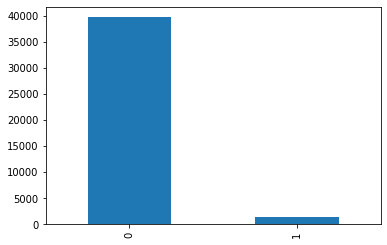

In [11]:
dataset.df['HIV_active'].value_counts().plot(kind='bar')

### Explore molecules (with RDKit)

https://www.rdkit.org/docs/cppapi/index.html

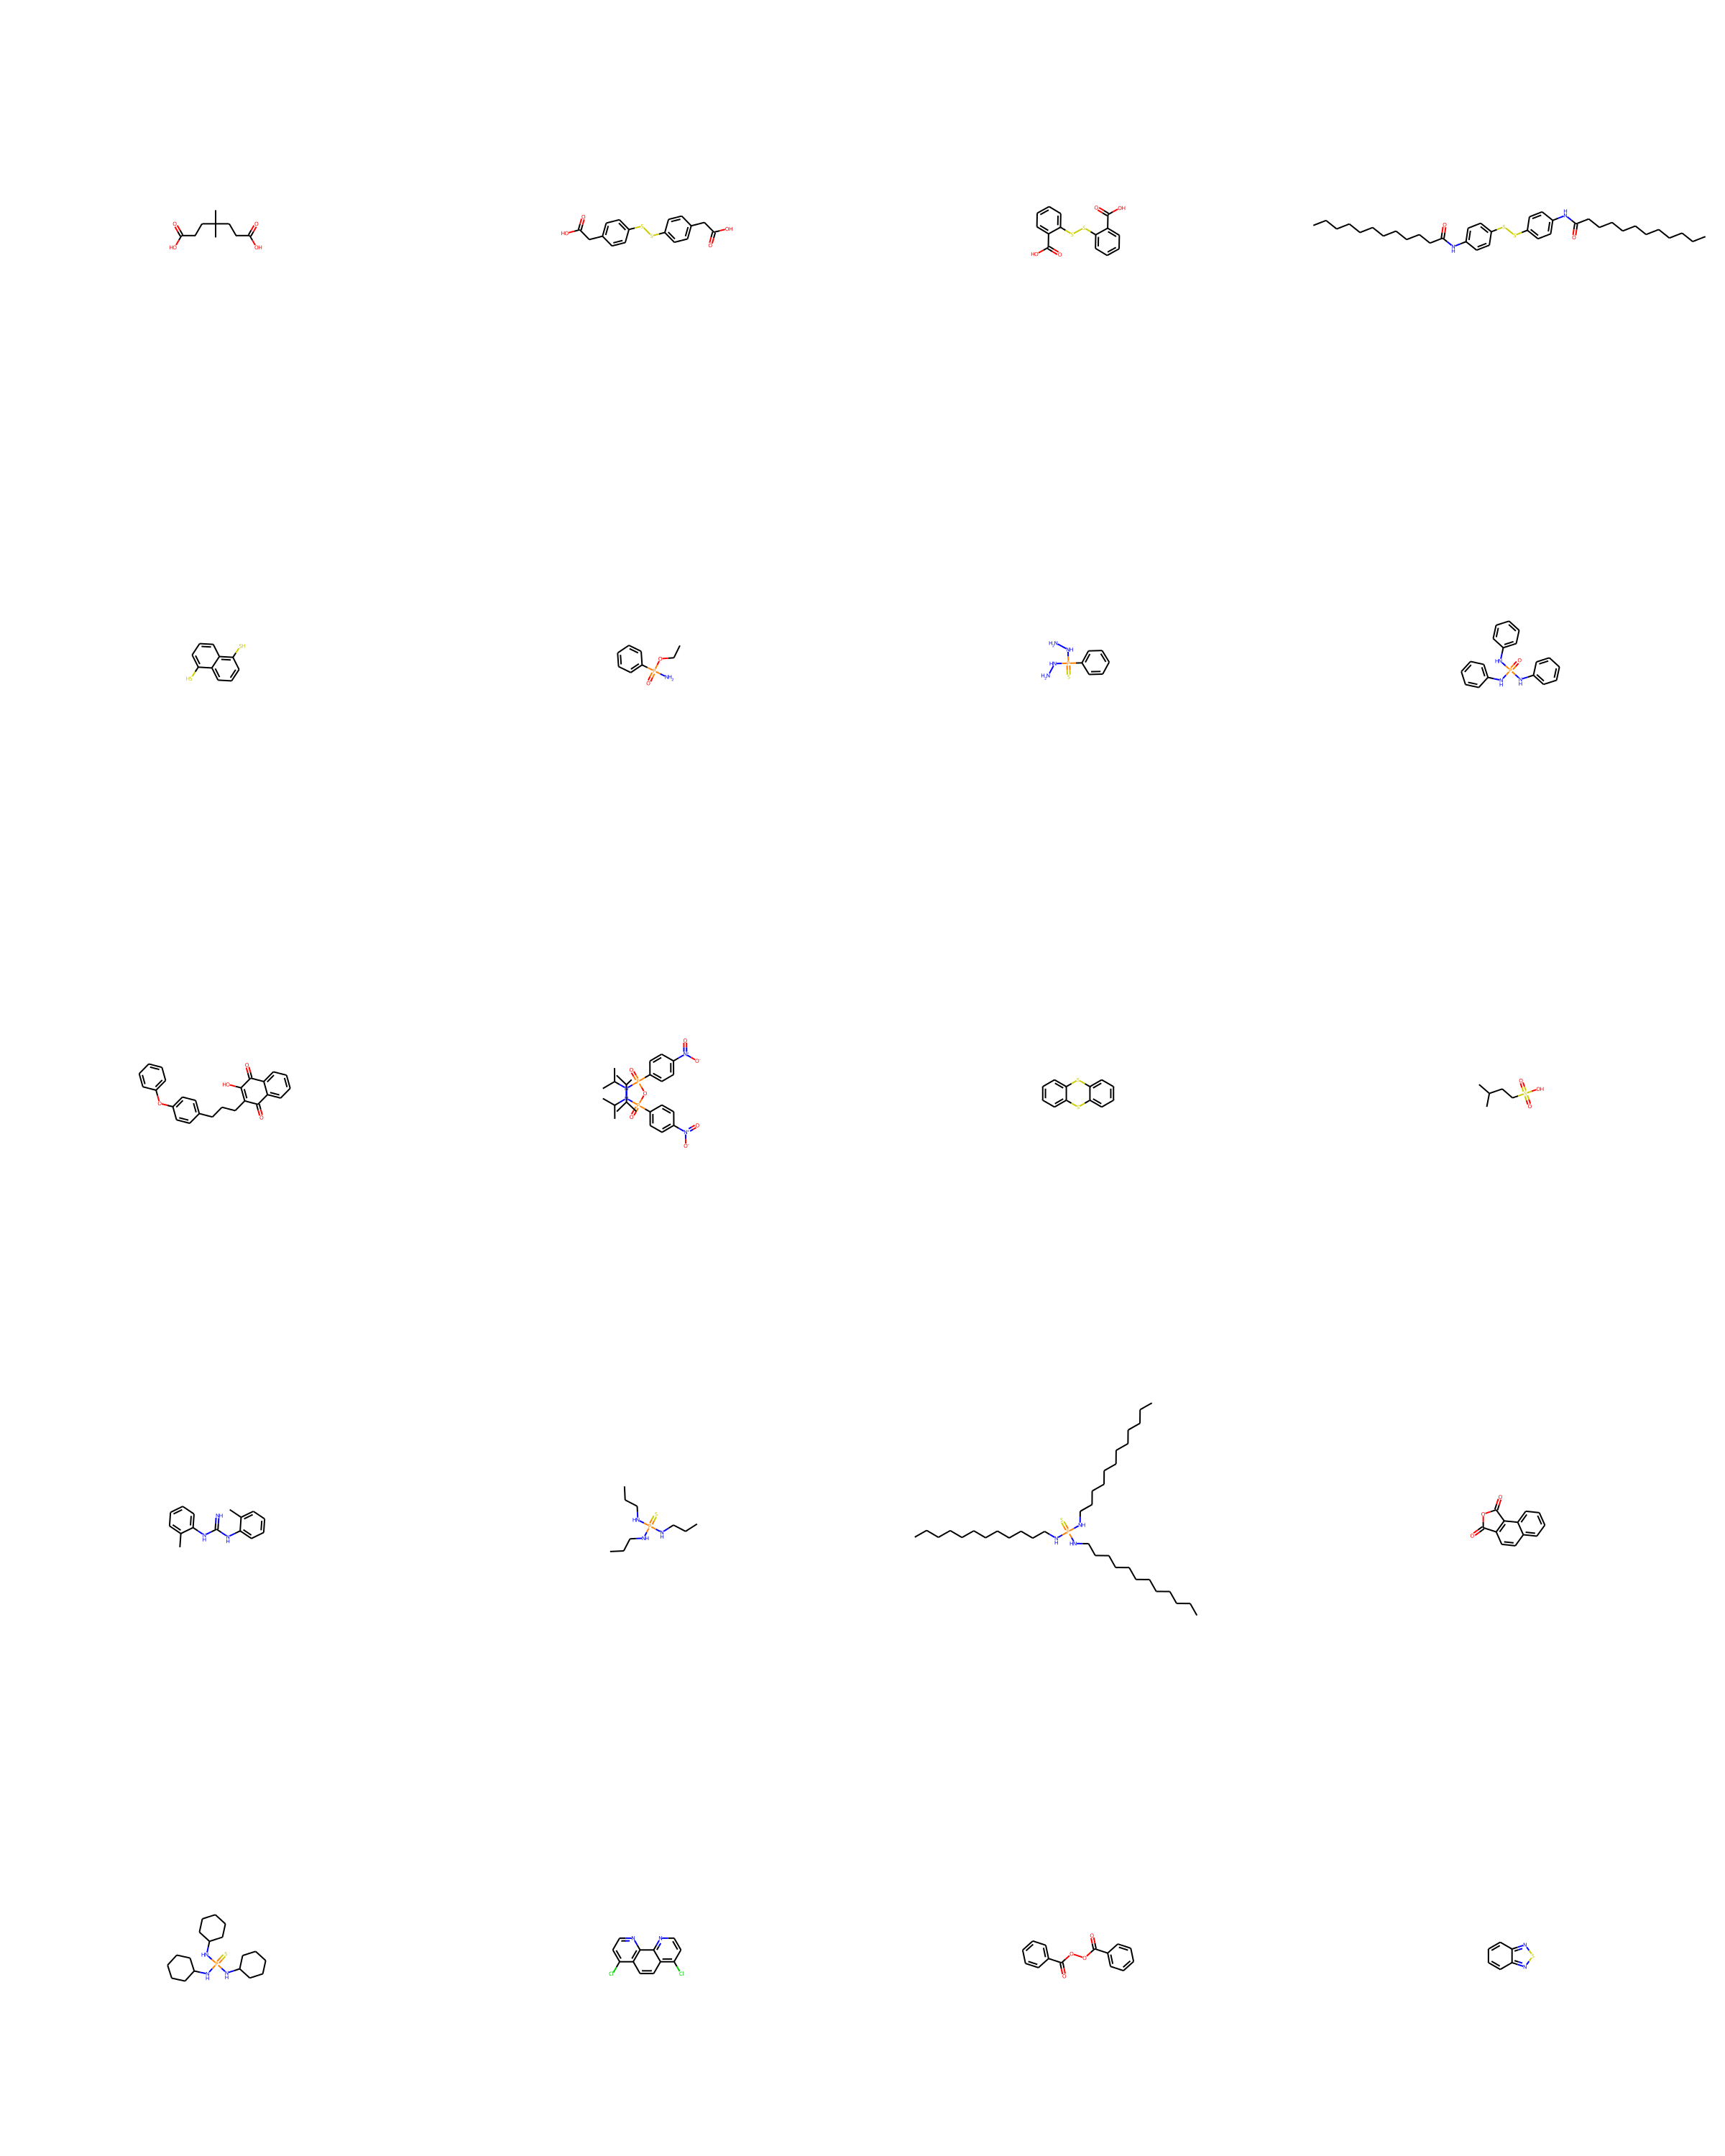

In [73]:
random_molecule_start_index = 10

sample_smiles = dataset.df['smiles'][random_molecule_start_index:random_molecule_start_index + 20].values
sample_molecules = [Chem.MolFromSmiles(smile) for smile in sample_smiles]
Draw.MolsToGridImage(sample_molecules, molsPerRow=4, subImgSize=(600, 600))

### Examine a random molecule 

In [86]:
sample_smiles[0]

'CC(C)(CCC(=O)O)CCC(=O)O'

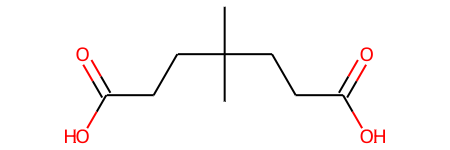

In [623]:
mol = sample_molecules[0]
mol

* Using the methods here we can further explore the features of the molecusle.
https://www.rdkit.org/docs/cppapi/classRDKit_1_1Atom.html

In [253]:
atoms = mol.GetAtoms()
print("Total number of atoms in the molecule : {}".format(len(atoms)))

Total number of atoms in the molecule : 13


In [254]:
molecule_atom_features = []
for atom in atoms:
    atom_features = {}
    atom_features['atomic_symbol'] = atom.GetSymbol()
    atom_features['atomic_numbers'] = atom.GetAtomicNum()
    atom_features['degree'] = atom.GetDegree()
    atom_features['formal_charge'] = atom.GetFormalCharge()
    atom_features['hybridization'] = atom.GetHybridization()
    atom_features['is_aromatic'] = atom.GetIsAromatic()
    molecule_atom_features.append(atom_features)
molecule_atom_features

[{'atomic_symbol': 'C',
  'atomic_numbers': 6,
  'degree': 1,
  'formal_charge': 0,
  'hybridization': rdkit.Chem.rdchem.HybridizationType.SP3,
  'is_aromatic': False},
 {'atomic_symbol': 'C',
  'atomic_numbers': 6,
  'degree': 4,
  'formal_charge': 0,
  'hybridization': rdkit.Chem.rdchem.HybridizationType.SP3,
  'is_aromatic': False},
 {'atomic_symbol': 'C',
  'atomic_numbers': 6,
  'degree': 1,
  'formal_charge': 0,
  'hybridization': rdkit.Chem.rdchem.HybridizationType.SP3,
  'is_aromatic': False},
 {'atomic_symbol': 'C',
  'atomic_numbers': 6,
  'degree': 2,
  'formal_charge': 0,
  'hybridization': rdkit.Chem.rdchem.HybridizationType.SP3,
  'is_aromatic': False},
 {'atomic_symbol': 'C',
  'atomic_numbers': 6,
  'degree': 2,
  'formal_charge': 0,
  'hybridization': rdkit.Chem.rdchem.HybridizationType.SP3,
  'is_aromatic': False},
 {'atomic_symbol': 'C',
  'atomic_numbers': 6,
  'degree': 3,
  'formal_charge': 0,
  'hybridization': rdkit.Chem.rdchem.HybridizationType.SP2,
  'is_aroma

* We can apply node-fearizer directly into the molecule like below and generate above results.

In [138]:
atom_featurizer = CanonicalAtomFeaturizer(atom_data_field='feat')
atom_featurizer(mol)

{'feat': tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
          1., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
          1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
          0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.

In [624]:
bonds = mol.GetBonds()
len(bonds)

12

In [256]:
molecule_bond_features = []
for bond in mol.GetBonds():
    bond_featrues = {}
    bond_featrues['bond_type'] = bond.GetBondTypeAsDouble()
    bond_featrues['id_in_ring'] = bond.IsInRing()
    molecule_bond_features.append(bond_featrues)
molecule_bond_features

[{'bond_type': 1.0, 'id_in_ring': False},
 {'bond_type': 1.0, 'id_in_ring': False},
 {'bond_type': 1.0, 'id_in_ring': False},
 {'bond_type': 1.0, 'id_in_ring': False},
 {'bond_type': 1.0, 'id_in_ring': False},
 {'bond_type': 2.0, 'id_in_ring': False},
 {'bond_type': 1.0, 'id_in_ring': False},
 {'bond_type': 1.0, 'id_in_ring': False},
 {'bond_type': 1.0, 'id_in_ring': False},
 {'bond_type': 1.0, 'id_in_ring': False},
 {'bond_type': 2.0, 'id_in_ring': False},
 {'bond_type': 1.0, 'id_in_ring': False}]

In [257]:
from rdkit.Chem import rdmolops

In [626]:
ajm = rdmolops.GetAdjacencyMatrix(mol)
ajm

array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]], dtype=int32)

In [633]:
np.ones((ajm.shape[0], 1))

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [642]:

ajm_with_sup = np.append(ajm, np.ones((ajm.shape[0], 1)), axis=1)
ajm_with_sup

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.]])

In [643]:
row, col = np.where(ajm_with_sup)

In [645]:
df = pd.DataFrame(list(zip(row,col)), columns = ["~from", "~to"])
df

,~from,~to
0,0,1
1,0,13
2,1,0
3,1,2
4,1,3
5,1,8
6,1,13
7,2,1
8,2,13
9,3,1


### Converting to Gremlin Dataset

In [688]:
from tqdm import tqdm

atom_featurizer = CanonicalAtomFeaturizer(atom_data_field='feat')


def super_atom(id, label=0):
    super_atom = {}
    super_atom['~id'] = id
    super_atom['~label'] = "sup"
    super_atom["HIV_active:String"] = label
    return super_atom

def all_node_features(molecule, label):
    i = 0
    molecule_node_features = []
    for atom in molecule.GetAtoms():
        atom_features = {}
        atom_features['~id'] = i
        atom_features['atomic_symbol:String'] = atom.GetSymbol()
        atom_features['atomic_numbers:Double'] = atom.GetAtomicNum()
        atom_features['degree:Double'] = atom.GetDegree()
        atom_features['formal_charge:Double'] = atom.GetFormalCharge()
        atom_features['hybridization:Double'] = atom.GetHybridization()
        atom_features['is_aromatic:Bool'] = atom.GetIsAromatic()
        atom_features['~label'] = "atom"
        molecule_node_features.append(atom_features)
        i = i + 1
    molecule_node_features.append(super_atom(i, label))    
    return molecule_node_features
    

def mol_prefixed_id(id_series, prefix):
    return prefix + id_series.astype(str) 

def all_edge_fearues(molecule, mol_prefix):
    i = 0
    molecule_bond_features = []
    for bond in mol.GetBonds():
        bond_featrues = {}
        bond_featrues['~id'] = i
        bond_featrues['bond_type:String'] = bond.GetBondTypeAsDouble()
        bond_featrues['id_in_ring:Bool'] = bond.IsInRing()
        molecule_bond_features.append(bond_featrues)
        i = i + 1
    return molecule_bond_features  

import os
def save_file(df, folder, file_name):
    location = "./graph-data/gremlin/{}".format(folder)
    df.to_csv("{}/{}.csv".format(location, file_name), index=None)
    

def adj_marix(molecule, mol_prefix):
    ajm = rdmolops.GetAdjacencyMatrix(molecule)
    ajm = np.append(ajm, np.ones((ajm.shape[0], 1)), axis=1)
    row, col = np.where(ajm)
    df = pd.DataFrame(np.array(list(zip(row,col))), columns = ["~from", "~to"])
    df['~id'] = df.index
    return df

def process_molecule_graph(smile, mol_prefix, label):
    molecule = Chem.MolFromSmiles(smile)
    node_features = pd.DataFrame(all_node_features(molecule, label))
    #edge_features = pd.DataFrame(all_edge_fearues(molecule, mol_prefix))
    
    node_features["~id"] = mol_prefixed_id(node_features["~id"], "n{}m".format(mol_prefix))
    #edge_features["~id"] = mol_prefixed_id(edge_features["~id"], "e{}".format(mol_prefix))
    
    adj_m = adj_marix(molecule, mol_prefix)
    adj_m["~from"] = mol_prefixed_id(adj_m["~from"], "n{}m".format(mol_prefix))
    adj_m["~to"] = mol_prefixed_id(adj_m["~to"], "n{}m".format(mol_prefix))
    adj_m["~id"] = mol_prefixed_id(adj_m["~id"], "e{}m".format(mol_prefix))
    
    save_file(node_features, "nodes" , "node{}".format(mol_prefix))
    save_file(adj_m, "edges", "edge{}".format(mol_prefix))
    



In [689]:
!rm -r graph-data 

os.makedirs("./graph-data/gremlin/nodes")
os.makedirs("./graph-data/gremlin/edges")

In [690]:
#sample_dataset = dataset.df
sample_dataset = dataset.df[0:1000]


sample_dataset['HIV_active'] = "class" + sample_dataset['HIV_active'].astype(str)
sample_dataset.head(10)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,smiles,HIV_active
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,class0
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,class0
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,class0
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,class0
4,O=S(=O)(O)CCS(=O)(=O)O,class0
5,CCOP(=O)(Nc1cccc(Cl)c1)OCC,class0
6,O=C(O)c1ccccc1O,class0
7,CC1=C2C(=COC(C)C2C)C(O)=C(C(=O)O)C1=O,class0
8,O=[N+]([O-])c1ccc(SSc2ccc([N+](=O)[O-])cc2[N+]...,class0
9,O=[N+]([O-])c1ccccc1SSc1ccccc1[N+](=O)[O-],class0


In [691]:
for index, mol in tqdm(sample_dataset.iterrows(), total=sample_dataset.shape[0]):
    process_molecule_graph(mol['smiles'], index, mol['HIV_active'])    
    

100%|██████████| 1000/1000 [00:22<00:00, 43.92it/s]


In [699]:
import sagemaker

sagemaker_session = sagemaker.Session()
BUCKET = sagemaker_session.default_bucket()
PREFIX = 'neptune-ml/hiv-inhibitor/neptune-import/samples'


In [700]:
"s3://{}/{}".format(BUCKET, PREFIX)

's3://sagemaker-us-west-2-431678540810/neptune-ml/hiv-inhibitor/neptune-import/samples'

In [701]:
!aws s3 cp --recursive ./graph-data/gremlin s3://$BUCKET/$PREFIX/


upload: graph-data/gremlin/edges/edge0.csv to s3://sagemaker-us-west-2-431678540810/neptune-ml/hiv-inhibitor/neptune-import/samples/edges/edge0.csv
upload: graph-data/gremlin/edges/edge105.csv to s3://sagemaker-us-west-2-431678540810/neptune-ml/hiv-inhibitor/neptune-import/samples/edges/edge105.csv
upload: graph-data/gremlin/edges/edge1.csv to s3://sagemaker-us-west-2-431678540810/neptune-ml/hiv-inhibitor/neptune-import/samples/edges/edge1.csv
upload: graph-data/gremlin/edges/edge10.csv to s3://sagemaker-us-west-2-431678540810/neptune-ml/hiv-inhibitor/neptune-import/samples/edges/edge10.csv
upload: graph-data/gremlin/edges/edge103.csv to s3://sagemaker-us-west-2-431678540810/neptune-ml/hiv-inhibitor/neptune-import/samples/edges/edge103.csv
upload: graph-data/gremlin/edges/edge104.csv to s3://sagemaker-us-west-2-431678540810/neptune-ml/hiv-inhibitor/neptune-import/samples/edges/edge104.csv
upload: graph-data/gremlin/edges/edge100.csv to s3://sagemaker-us-west-2-431678540810/neptune-ml/h

### Save to file

In [19]:
mol_nodes_df.to_csv("graph-data/mol_nodes.csv")
mol_edges_df.to_csv("graph-data/mol_edges.csv")

In [13]:
dataset.graphs[0].edges()[0].numpy(),dataset.graphs[0].edges()[1].numpy()

(array([ 0,  8,  8, 13, 13, 17, 17,  1,  1,  7,  7, 12, 12, 16, 16,  9, 12,
        14,  1,  3,  3,  5,  5, 10, 10, 18,  5,  2,  2,  6,  6, 11, 11, 15,
         6,  4, 14, 13,  4,  1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
        11, 12, 13, 14, 15, 16, 17, 18], dtype=int32),
 array([ 8,  0, 13,  8, 17, 13,  1, 17,  7,  1, 12,  7, 16, 12,  9, 16, 14,
        12,  3,  1,  5,  3, 10,  5, 18, 10,  2,  5,  6,  2, 11,  6, 15, 11,
         4,  6, 13, 14,  1,  4,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
        11, 12, 13, 14, 15, 16, 17, 18], dtype=int32))

In [1]:
dataset.graphs[0].nodes()

NameError: name 'dataset' is not defined

In [ ]:
dataset = pd.DataFrame({'label': label, 'images': list(images)}, columns=['label', 'images'])
